# Final project


We wish to analyse the sentiments of the characters and the average sentiments of the communities. The communities being the ones obtained by the algorithm and the ones obtained by splitting the characters into their houses, their religions and their cultures. We wish to compare the community splits and see which ones best characterises their sentiments. 

## Imports


In [253]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community
import json

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import linregress

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

## Helper functions

In [254]:
def get_sentiments(text, dict_avg):
    text_tokens = word_tokenize(text)
    text_words = [w.lower() for w in text_tokens if w.isalpha()]
    fdist = FreqDist(text_words)
    total_count = 0
    sentiment = 0
    for w in fdist:
        if w in dict_avg:
            sentiment += dict_avg[w]*fdist[w]
            total_count += fdist[w]
    if total_count == 0:
        return 0
    sentiment /= total_count
    return sentiment

In [255]:
def get_TFTR(text1, text2, c = 1, weighted = False, sentiment_words=None):

    stopwords = nltk.corpus.stopwords.words('english')

    text1_tokens = word_tokenize(text1)
    text1_words = [w.lower() for w in text1_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]

    text2_tokens = word_tokenize(text2)
    text2_words = [w.lower() for w in text2_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]
    
    if sentiment_words is not None:
        text1_words = [w for w in text1_words if w in sentiment_words]
        text2_words = [w for w in text2_words if w in sentiment_words]
        
    if weighted:
        r1 = len(text2_words)/len(text1_words)
        r2 = len(text1_words)/len(text2_words)
        if r1 > r2:
            r1 = 1
        else:
            r2 = 1
    else:
        r1 = 1
        r2 = 1

    fdist1 = FreqDist(text1_words)
    fdist2 = FreqDist(text2_words)

    dict1_TFTR = dict()
    dict2_TFTR = dict()

    for w in fdist1:
        if w in fdist2:
            weight1 = fdist1[w]*r1/(fdist2[w]*r2+c)
        else:
            weight1 = fdist1[w]*r1/c
        dict1_TFTR[w] = weight1*fdist1[w]*r1
        
    for w in fdist2:
        if w in fdist1:
            weight2 = fdist2[w]*r2/(fdist1[w]*r1+c)
        else:
            weight2 = fdist2[w]*r2/c
        dict2_TFTR[w] = weight2*fdist2[w]*r2

    dict1_TFTR = dict(sorted(dict1_TFTR.items(), key=lambda x:x[1], reverse=True))
    dict2_TFTR = dict(sorted(dict2_TFTR.items(), key=lambda x:x[1], reverse=True))

    return dict1_TFTR, dict2_TFTR, fdist1, fdist2


Connectedness

In [256]:
def connected_character(node_name, graph, main_house_analysis=False):
    # Select a node
    successors = graph.successors(node_name)
    predecessors = graph.predecessors(node_name)
    linked_nodes = set(successors) | set(predecessors)

    if main_house_analysis:
        return linked_nodes

    # Get all the houses the character is a part of
    node_houses = graph.nodes(data=True)[node_name]['houses']
    node_houses = node_houses.split(', ')

    # Remove all the nodes that are a part of the same house
    filtered_nodes = []
    for node in linked_nodes:
        destination_houses = graph.nodes[node].get('houses').split(', ')
        checker = True
        for destination_house in destination_houses:
            if destination_house in node_houses:
                checker = False

        if checker:
            filtered_nodes.append(node)
    
    return filtered_nodes

In [257]:
# Get all the connected characters to a house
def get_connected_to_house(house, graph):
    connected_to_house = []

    # Get all the characters from the desired house?
    nodes_with_attribute = [node for node, data in graph.nodes(data=True) if house in data.get('houses')]
    for ch in nodes_with_attribute:
        connected_to_house.extend(connected_character(ch, graph))

    return(connected_to_house)

In [258]:
def count_connection_to_house(character_list, graph, houses_list):
    houses_of_character_list = []
    connected_houses_freq = {}

    for character in character_list:
        node_data = graph.nodes(data=True)[character]['houses'].split(', ')
        houses_of_character_list.extend(node_data)

    for house in houses_list:
        connected_houses_freq[house] = houses_of_character_list.count(house)

    return dict(sorted(connected_houses_freq.items(), key=lambda x: x[1], reverse=True))

In [259]:
def main_house(character, graph, houses_list):
    filtered_most_connected_houses = {}
    cc = connected_character(character, graph, main_house_analysis=True)

    node_houses = graph.nodes(data=True)[character]['houses']
    node_houses = node_houses.split(', ')
    most_connected_houses = count_connection_to_house(character_list=cc, graph=graph, houses_list=houses_list)

    for house in most_connected_houses:
        if house in node_houses:
            filtered_most_connected_houses[house] = most_connected_houses[house]

    return max(filtered_most_connected_houses)

## Loading the data

In [260]:
if (not os.path.exists('files/names.csv')) or (not os.path.exists('files/houses.csv')) or (not os.path.exists('files/cultures.csv')) or (not os.path.exists('files/religions.csv')) or (not os.path.exists('files/wiki_texts/')) or (not os.path.exists('files/characters.json')):
    # create paths
    if not os.path.exists('files'):
        os.mkdir('files')
    if not os.path.exists('files/wiki_texts'):
        os.mkdir('files/wiki_texts')

    baseurl = "https://gameofthrones.fandom.com/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    site = 'Game_of_Thrones'
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": site
    }

    # Send the API request to retrieve the content
    response = requests.get(baseurl, params=params)
    data = response.json()

    # Extract the text content
    page_id = list(data['query']['pages'].keys())[0]
    text_content = data['query']['pages'][page_id]['revisions'][0]['*']

    cast = text_content[text_content.find("==Cast=="):text_content.find("==Crew==")]

    # find all lines starting with *
    lines = cast.split('\n')
    lines = [line for line in lines if line.startswith('*')]
    lines_chars = [line[line.find("as "):] for line in lines]
    # extract the names
    pattern = r'\[{2}(.+?)\]{2}'
    names = [re.findall(pattern, line)[0] for line in lines_chars]
    names = [name.split('|')[0] for name in names]

    names.remove('Archmaester')
    names.append('Ebrose')
    names.remove('Khal')
    names.append('Drogo')

    # save names to csv
    names_df = pd.DataFrame(names, columns=['Name'])
    names_df.to_csv('files/names.csv', index=False)


    characters = {}
    houses_list = []
    religions_list = []
    cultures_list = []

    for name in names:
        print(name)
        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": name
        }

        # Send the API request to retrieve the content
        response = requests.get(baseurl, params=params)
        data = response.json()

        # Extract the text content
        page_id = list(data['query']['pages'].keys())[0]
        text_content = data['query']['pages'][page_id]['revisions'][0]['*']
        
        # save text content to text file
        with open('files/wiki_texts/' + name + '.txt', 'w') as f:
            f.write(text_content)

        # find line with | House
        try:
            house_line = re.findall(r'\| House (.+)', text_content)[0]
            houses = re.findall(pattern, house_line)
            if len(houses) == 0:
                houses = ['No house']
        except:
            houses = ['No house']


        seasons_line = re.findall(r'\| Season (.+)', text_content)[0]
        seasons = re.findall(pattern, seasons_line)

        culture_line = re.findall(r'\| Culture (.+)', text_content)[0]
        culture = re.findall(pattern, culture_line)
        try:
            culture = culture[0].split('|')[0]
        except:
            culture = 'No culture'

        if culture not in cultures_list:
            cultures_list.append(culture)

        religion_line = re.findall(r'\| Religion (.+)', text_content)[0]
        religion = re.findall(pattern, religion_line)
        try:
            religion = religion[0].split('|')[0]
        except:
            religion = 'No religion'

        if religion not in religions_list:
            religions_list.append(religion)

        death_line = re.findall(r'\| Death (.+)', text_content)[0]
        death = re.findall(pattern, death_line)
        try:
            death = death[0].split('|')[0].split(' ')
            death = int(death[0])
        except:
            death = -1 # not dead or unknown
        num_episodes = re.findall(r'\| Appearances (.+)', text_content)[0]
        num_episodes = num_episodes.split(' ')[1]
        try:
            num_episodes = int(num_episodes)
        except:
            num_episodes = 1
        print(num_episodes)


        characters[name] = {'houses': [], 'seasons': [], 'num_episodes': num_episodes, 'culture': culture, 'religion': religion, 'death': death, 'tex_len': 0, 'sentiment': 0}
        for house in houses:
            house = house.split('|')[0]
            if house == 'Legitimization':
                continue
            if house == 'House Baratheon of King\'s Landing' or house == 'House Baratheon of Dragonstone':
                house = 'House Baratheon'
            if house not in houses_list:
                houses_list.append(house)
            if house not in characters[name]['houses']:
                characters[name]['houses'].append(house)

        for season in seasons:
            season = season.split('|')[-1]
            characters[name]['seasons'].append(int(season))


    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)

    # save houses to csv
    houses_df = pd.DataFrame(houses_list, columns=['House'])
    houses_df.to_csv('files/houses.csv', index=False)

    cultures_df = pd.DataFrame(cultures_list, columns=['Culture'])
    cultures_df.to_csv('files/cultures.csv', index=False)

    religions_df = pd.DataFrame(religions_list, columns=['Religion'])
    religions_df.to_csv('files/religions.csv', index=False)
    
else:
    print('Loading characters and houses from files')

    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)

    houses_df = pd.read_csv('files/houses.csv')
    houses_list = list(houses_df['House'])

    names_df = pd.read_csv('files/names.csv')
    names = list(names_df['Name'])

    cultures_df = pd.read_csv('files/cultures.csv')
    cultures_list = list(cultures_df['Culture'])

    religions_df = pd.read_csv('files/religions.csv')
    religions_list = list(religions_df['Religion'])


Loading characters and houses from files


TypeError: 'NoneType' object is not callable

In [ ]:
df_sentiments = pd.read_csv('files/LabMT.txt', sep='\t')
dict_avg_sentiments = {}
for i in range(len(df_sentiments)):
    dict_avg_sentiments[df_sentiments['word'][i]] = df_sentiments['happiness_average'][i]

## Creating the graph

In [ ]:
if (not os.path.exists('files/di_G.gexf')):
    
    pattern = r'\[{2}(.+?)\]{2}'
    
    di_G = nx.DiGraph()

    for name in names:
        houses = characters[name]['houses']
        first_house = houses[0]
        houses_string = ', '.join(houses)
        seasons = characters[name]['seasons']
        seasons_string = ', '.join([str(season) for season in seasons])
        first_season = seasons[0]
        last_season = seasons[-1]
        num_episodes = characters[name]['num_episodes']
        culture = characters[name]['culture']
        religion = characters[name]['religion']
        death = characters[name]['death']
        num_seasons = len(seasons)

        di_G.add_node(name, houses=houses_string, main_house='', seasons=seasons_string, num_seasons=num_seasons, num_episodes=num_episodes, culture=culture, religion=religion, death=death, text_len=0, sentiment=0)

    # add edges
    for name in names:
        # load text
        with open('files/wiki_texts/' + name + '.txt', 'r') as f:
            text = f.read()
        text_len = len(text)

        sentiment = get_sentiments(text, dict_avg_sentiments)

        characters[name]['text_len'] = text_len
        characters[name]['sentiment'] = sentiment

        di_G.nodes[name]['text_len'] = text_len
        di_G.nodes[name]['sentiment'] = sentiment
        
        # extract all links
        links = re.findall(pattern, text)
        # extract all links that are characters
        char_links = [link.split('|')[0] for link in links if link in names]
        # add edges
        for char_link in char_links:
            di_G.add_edge(name, char_link)

    # Add main house attribute
    for name in names:
        di_G.nodes[name]['main_house'] = main_house(name, di_G, houses_list)
        
    G = di_G.to_undirected()

    print('All characters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))
    print('Excluding charecters without houses:')

    nx.write_gexf(di_G, "files/di_G.gexf")

    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)

else:
    print('Loading graphs from file')
    di_G = nx.read_gexf("files/di_G.gexf")
    G = di_G.to_undirected()

    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)

    print('All characters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))
    print('Excluding charecters without houses:')
    

Loading graphs from file
All characters:
DiGraph with 221 nodes and 3719 edges
Number of connected components:  1
Excluding charecters without houses:


## Visualising the graph

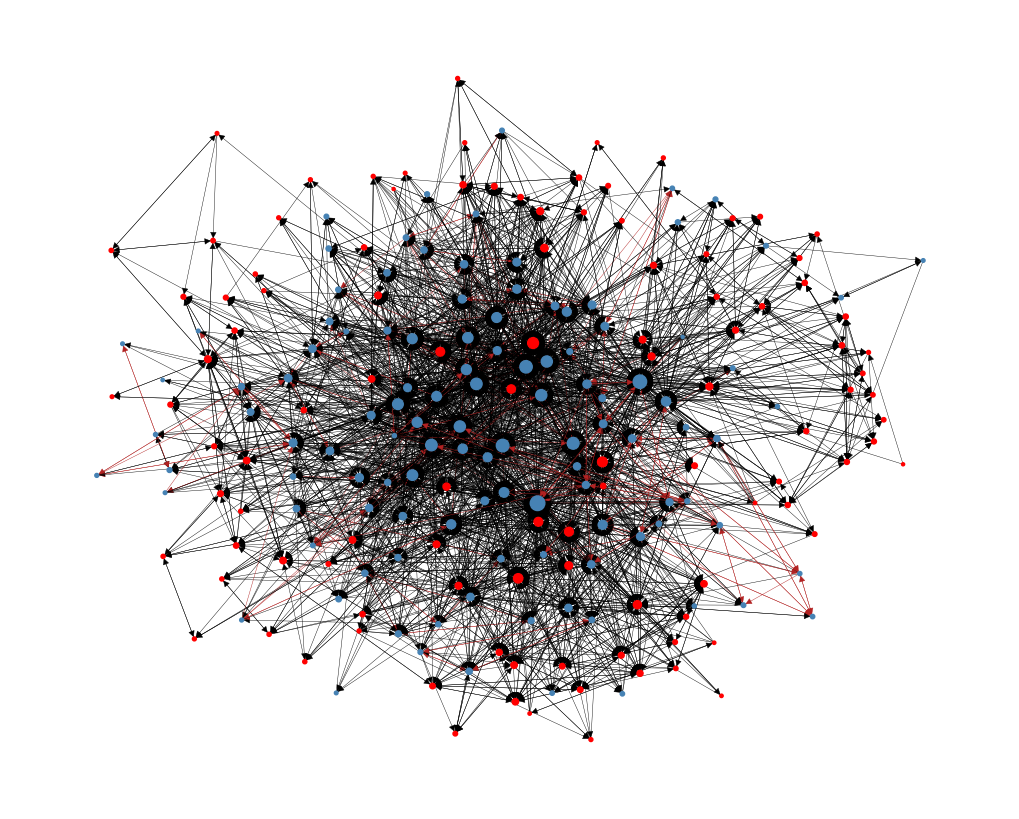

In [ ]:
# make a color pallet for the houses
num_houses = len(houses_list)

colors = ['red' if di_G.nodes[node]['houses']=='No house' else 'steelblue' for node in di_G]

node_sizes = [di_G.in_degree(node)+5 for node in di_G]

edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    houses_0 = node_0['houses'].split(', ')
    houses_1 = node_1['houses'].split(', ')

    common_house = False
    for house_0 in houses_0:
        if house_0 in houses_1 and house_0 != 'No house':
            common_house = True
            break
    
    if common_house:
        edge_colors.append('firebrick')
    else:
        edge_colors.append('black')

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color=colors, edge_color=edge_colors, width=0.3, with_labels=False)
plt.show()

## Network statistics

In [ ]:
# Get house sizes
house_sizes = {}
for house in houses_list:
    house_sizes[house] = 0

for name in names:
    houses = characters[name]['houses']
    for house in houses:
        house_sizes[house] += 1

# sort house sizes
house_sizes = dict(sorted(house_sizes.items(), key=lambda x: x[1], reverse=True))
print(house_sizes)

# Get culture sizes
culture_sizes = {}
for culture in cultures_list:
    culture_sizes[culture] = 0

for name in names:
    culture = characters[name]['culture']
    culture_sizes[culture] += 1

# sort culture sizes
culture_sizes = dict(sorted(culture_sizes.items(), key=lambda x: x[1], reverse=True))
print(culture_sizes)

# Get religion sizes
religion_sizes = {}
for religion in religions_list:
    religion_sizes[religion] = 0

for name in names:
    religion = characters[name]['religion']
    religion_sizes[religion] += 1

# sort religion sizes
religion_sizes = dict(sorted(religion_sizes.items(), key=lambda x: x[1], reverse=True))
print(religion_sizes)

# average text lengths
text_lengths = [di_G.nodes[node]['text_len'] for node in di_G.nodes()]
avg_text_len = np.mean(text_lengths)
print(f'Average text length: {avg_text_len}')


k_in = di_G.in_degree
k_out = di_G.out_degree
print(sorted(k_in, key=lambda x: x[1], reverse=True))
print(sorted(k_out, key=lambda x: x[1], reverse=True))


{'No house': 109, 'House Stark': 13, 'House Baratheon': 11, 'House Lannister': 9, 'House Targaryen': 7, 'House Frey': 6, 'House Tully': 5, 'House Greyjoy': 5, 'House Tarly': 5, 'House Bolton': 4, 'House Tyrell': 4, 'House Cassel': 3, 'House Umber': 3, 'House Karstark': 3, 'House Mormont': 3, 'House Reed': 3, 'House Martell': 3, 'House Payne': 2, 'House Clegane': 2, 'House Florent': 2, 'House Seaworth': 2, 'House Arryn': 2, 'House Baelish': 2, 'House Waynwood': 2, 'House Glover': 1, 'House Cerwyn': 1, 'House Manderly': 1, 'House Lorch': 1, 'House Tarth': 1, 'House Egen': 1, 'House Royce': 1, 'House Corbray': 1, 'House Redwyne': 1, 'House Kenning': 1, 'House Erenford': 1, "Bronn's house": 1, 'Maegyr family': 1, 'House Selmy': 1, 'House Trant': 1, 'House Dondarrion': 1, 'House Slynt': 1, 'House Stokeworth': 1, 'House Hollard': 1, 'House Thorne': 1, 'House Marsh': 1, 'House Yarwyck': 1, 'House Tollett': 1, 'House Mallister': 1, 'House Strickland': 1, 'House of Nakloz': 1, 'House of Ullhor'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
correlation coefficient: 0.9039302686134748
correlation coefficient: 0.917106296817839
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
slope: 1992.1487038323885
intercept: -7041.285201595714
r_value: 0.9171062968178382


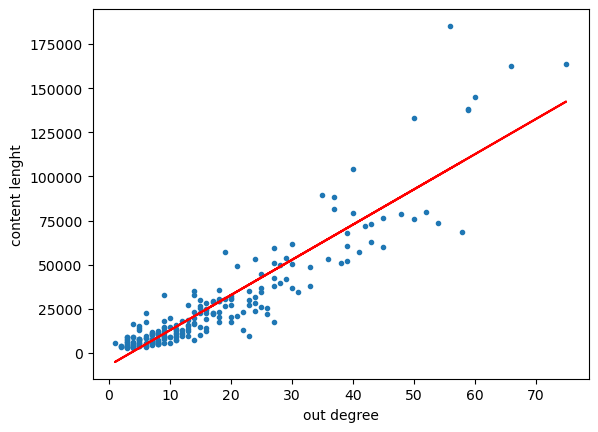

In [ ]:
# check correlation between out degree and content length
content_lenght = np.array([d for n, d in di_G.nodes(data='text_len')])
k_out_array = np.array([d for n, d in k_out])

# calculate spearman correlation coefficient
corr, p = spearmanr(k_out_array, content_lenght)
print(f'correlation coefficient: {corr}')

# calculate pearson correlation coefficient
corr, p = pearsonr(k_out_array, content_lenght)
print(f'correlation coefficient: {corr}')

# fit line to data
slope, intercept, r_value, p_value, std_err = linregress(k_out_array, content_lenght)
print(f'slope: {slope}')
print(f'intercept: {intercept}')
print(f'r_value: {r_value}')

plt.plot(k_out_array, content_lenght, '.')
plt.plot(k_out_array, intercept + slope*k_out_array, 'r', label='fitted line')
plt.xlabel('out degree')
plt.ylabel('content lenght')
plt.show()


In [ ]:
N = len(di_G.nodes())
k_in = [di_G.in_degree(node) for node in di_G.nodes()]
k_out = [di_G.out_degree(node) for node in di_G.nodes()]
avg_k_in = np.mean(k_in)
avg_k_out = np.mean(k_out)
avg_k_in_sq = np.mean(np.square(k_in))
avg_k_out_sq = np.mean(np.square(k_out))
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha


print("<k_in>", avg_k_in)
print("<k_out>", avg_k_out)

print("<k_in^2>", avg_k_in_sq)
print("<k_out^2>", avg_k_out_sq)

print(f'lnN = {np.log(N)}')

print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

<k_in> 16.828054298642535
<k_out> 16.828054298642535
<k_in^2> 571.7692307692307
<k_out^2> 485.5429864253394
lnN = 5.3981627015177525
alpha in: 2.7021854011900404
alpha out: 3.0860797026662947


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/opt/anaconda3/envs/e1_social_graph/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


### Degree distribution

min out-degree: 0
max out-degree: 105


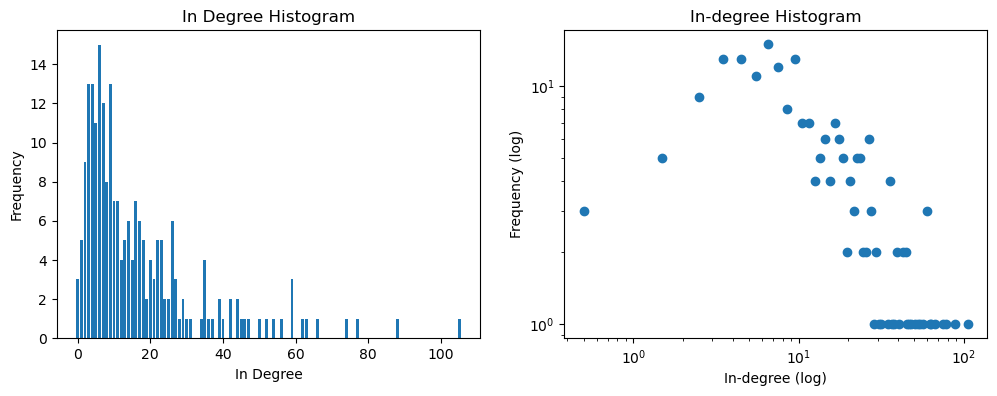

In [ ]:
max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(f'min out-degree: {min_k_in}')
print(f'max out-degree: {max_k_in}')
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].bar(bins_in[:-1], counts_in)

ax[0].set_title("In Degree Histogram")
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("In Degree")

ax[1].loglog((bins_in[:-1]+bins_in[1:])/2, counts_in, 'o')

ax[1].set_title("In-degree Histogram")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_xlabel("In-degree (log)")
plt.show()

min out-degree: 1
max out-degree: 75


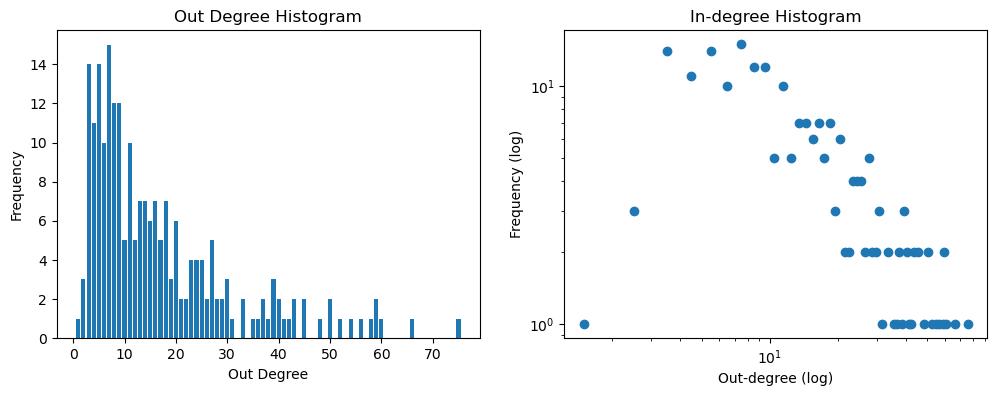

In [ ]:
max_k_out = max(k_out)
min_k_out = min(k_out)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_out, max_k_out+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].bar(bins_out[:-1], counts_out)
ax[0].set_title("Out Degree Histogram")
ax[0].set_xlabel("Out Degree")
ax[0].set_ylabel("Frequency")

ax[1].loglog((bins_out[:-1]+bins_out[1:])/2, counts_out, 'o')

ax[1].set_title("In-degree Histogram")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_xlabel("Out-degree (log)")
plt.show()

## Centrality

In [ ]:
centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

centrality = dict(sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5])
betweenness = dict(sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5])
eigenvector = dict(sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:5])
print(centrality)
print(betweenness)
print(eigenvector)

r_content_lenght = nx.attribute_assortativity_coefficient(di_G, 'text_len')
print(f'assortativity coefficient: {r_content_lenght}')
r_content_lenght = nx.attribute_assortativity_coefficient(G, 'text_len')
print(f'assortativity coefficient: {r_content_lenght}')

r_houses = nx.attribute_assortativity_coefficient(di_G, 'houses')
print(f'assortativity coefficient: {r_houses}')
r_houses = nx.attribute_assortativity_coefficient(G, 'houses')
print(f'assortativity coefficient: {r_houses}')

{'Jon Snow': 0.5045454545454545, 'Tyrion Lannister': 0.42727272727272725, 'Daenerys Targaryen': 0.41818181818181815, 'Eddard Stark': 0.39999999999999997, 'Sansa Stark': 0.3727272727272727}
{'Daenerys Targaryen': 0.11239286778749949, 'Jon Snow': 0.10053199606988947, 'Tyrion Lannister': 0.06379067034518995, 'Arya Stark': 0.05685853589905729, 'Eddard Stark': 0.04416247284325617}
{'Jon Snow': 0.19199763533967915, 'Tyrion Lannister': 0.18668418429321548, 'Eddard Stark': 0.17729375334231987, 'Sansa Stark': 0.17657101268784775, 'Jaime Lannister': 0.17455065486419988}
assortativity coefficient: -0.008075486561239353
assortativity coefficient: -0.008017543539508438
assortativity coefficient: 0.06682564325080893
assortativity coefficient: 0.05379174486368496


## Communities

In [ ]:
best_partition = community.best_partition(G, random_state = 42)
print(f'Number of communities: {len(set(best_partition.values()))}')
best_M = community.modularity(best_partition, G)
print(best_M)

best_partition_sizes = dict(FreqDist(list(best_partition.values())))
best_partition_sizes = dict(sorted(best_partition_sizes.items(), key=lambda x:x[1], reverse=True))
print(best_partition_sizes)

Number of communities: 6
0.3358652574965447
{4: 56, 1: 52, 5: 45, 2: 35, 3: 24, 0: 9}


In [ ]:
birth_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses_list):
    dict_houses[house] = i

for node in G.nodes():
    birth_house = G.nodes[node]['houses'].split(', ')[0]
    birth_house_partition[node] = dict_houses[birth_house]
    
birth_house_M = community.modularity(birth_house_partition, G)
print(birth_house_M)

0.052507812030527026


In [ ]:
last_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses_list):
    dict_houses[house] = i

for node in G.nodes():
    last_house = G.nodes[node]['houses'].split(', ')[-1]
    last_house_partition[node] = dict_houses[last_house]
    
last_house_M = community.modularity(last_house_partition, G)
print(last_house_M)

0.05651523345952769


In [ ]:
second_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses_list):
    dict_houses[house] = i

for node in G.nodes():
    try:
        second_house = G.nodes[node]['houses'].split(', ')[1]
    except:
        second_house = G.nodes[node]['houses']
    second_house_partition[node] = dict_houses[second_house]
    
second_house_M = community.modularity(second_house_partition, G)
print(second_house_M)

0.05561775133705908


In [ ]:
culture_partition = {}
dict_cultures = {}
for i, culture in enumerate(cultures_list):
    dict_cultures[culture] = i

for node in G.nodes():
    culture = G.nodes[node]['culture']
    culture_partition[node] = dict_cultures[culture]
    
culture_M = community.modularity(culture_partition, G)
print(culture_M)

0.06231258638302985


In [ ]:
religion_partition = {}
dict_religions = {}
for i, religion in enumerate(religions_list):
    dict_religions[religion] = i

for node in G.nodes():
    religion = G.nodes[node]['religion']
    religion_partition[node] = dict_religions[religion]
    
religion_M = community.modularity(religion_partition, G)
print(religion_M)

0.07787107145003307


## Connectedness

In [261]:
def freq_connected_houses_to(house):
    s1 = get_connected_to_house(house, di_G)
    s2 = count_connection_to_house(s1, di_G, houses_list=houses_list)

    return s2

freq_connected_houses_to("House Stark")

{'No house': 143,
 'House Baratheon': 53,
 'House Lannister': 34,
 'House Targaryen': 32,
 'House Frey': 18,
 'House Greyjoy': 17,
 'House Tyrell': 16,
 'House Tully': 14,
 'House Bolton': 13,
 'House Baelish': 13,
 'House Reed': 11,
 'House Karstark': 10,
 'House Mormont': 10,
 'House Cassel': 9,
 'House Umber': 9,
 'House Tarly': 9,
 'House Clegane': 8,
 'House Arryn': 8,
 'House Payne': 7,
 'House Seaworth': 7,
 'House Tarth': 6,
 'House Glover': 5,
 'House Royce': 5,
 'House Selmy': 5,
 'House Redwyne': 4,
 'House Martell': 4,
 'House Trant': 4,
 'House Dondarrion': 4,
 'House Dayne': 4,
 'House Hightower': 4,
 'House Manderly': 3,
 'House Waynwood': 3,
 "Bronn's house": 3,
 'House Hollard': 3,
 'House Lorch': 2,
 'House Erenford': 2,
 'House Thorne': 2,
 'House Tollett': 2,
 'House Egen': 1,
 'House Corbray': 1,
 'House Slynt': 1,
 'House Yarwyck': 1,
 'House Stark': 0,
 'House Cerwyn': 0,
 'House Florent': 0,
 'House Kenning': 0,
 'Maegyr family': 0,
 'House Stokeworth': 0,
 'Hou

## Sentiment analysis

In [ ]:
all_corpus = PlaintextCorpusReader('files/wiki_texts', '.*')
characters_sentiments = {}
for name in names:
    characters_sentiments[name] = characters[name]['sentiment']

sentiments=dict(sorted(characters_sentiments.items(), key=lambda x:x[1], reverse=True))
print(sentiments)

{'Talla Tarly': 5.529004854368929, 'Walda Bolton': 5.521348511383533, 'Melessa Tarly': 5.510585858585858, 'Roslin Tully': 5.505944309927355, 'Bernadette': 5.495778688524588, 'Ternesio Terys': 5.481174698795179, 'Moro': 5.467292724196272, 'Kitty Frey': 5.4630616740088085, 'Joyeuse Frey': 5.462453987730059, 'Anya Waynwood': 5.458746666666665, 'Lollys Stokeworth': 5.457144970414198, 'Leaf': 5.449579684763569, 'Donnel Waynwood': 5.433333333333334, 'High Septon (Joffrey)': 5.428569051580697, 'Steelshanks': 5.4272631578947355, 'Prendahl na Ghezn': 5.426723549488054, 'Matthos Seaworth': 5.425050125313277, 'Selyse Baratheon': 5.424962025316458, 'Zanrush': 5.420472440944881, 'Lyanna Stark': 5.41957794034891, 'Ros': 5.413762096774191, 'Caleotte': 5.41016501650165, 'Marei': 5.40864636209813, 'Vance Corbray': 5.405808580858083, 'Lothar Frey': 5.404445488721796, 'Tycho Nestoris': 5.400397140587768, 'Dim Dalba': 5.39978873239437, 'Shireen Baratheon': 5.397005907626205, 'Walder Frey': 5.3963064889918

5.169454094292797
5.529004854368929


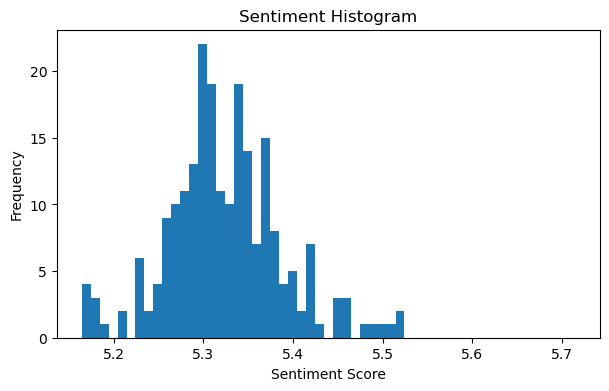

In [ ]:
sentiments_list = list(sentiments.values())
max_s = max(sentiments_list)
min_s = min(sentiments_list)
print(min_s)
print(max_s)


v = np.arange(min_s, max_s + 0.2, 0.01)

s_counts, s_bins = np.histogram(sentiments_list, bins=v)

plt.figure(figsize=(7,4))
plt.bar(s_bins[:-1], s_counts, width=np.diff(s_bins))
plt.title("Sentiment Histogram")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

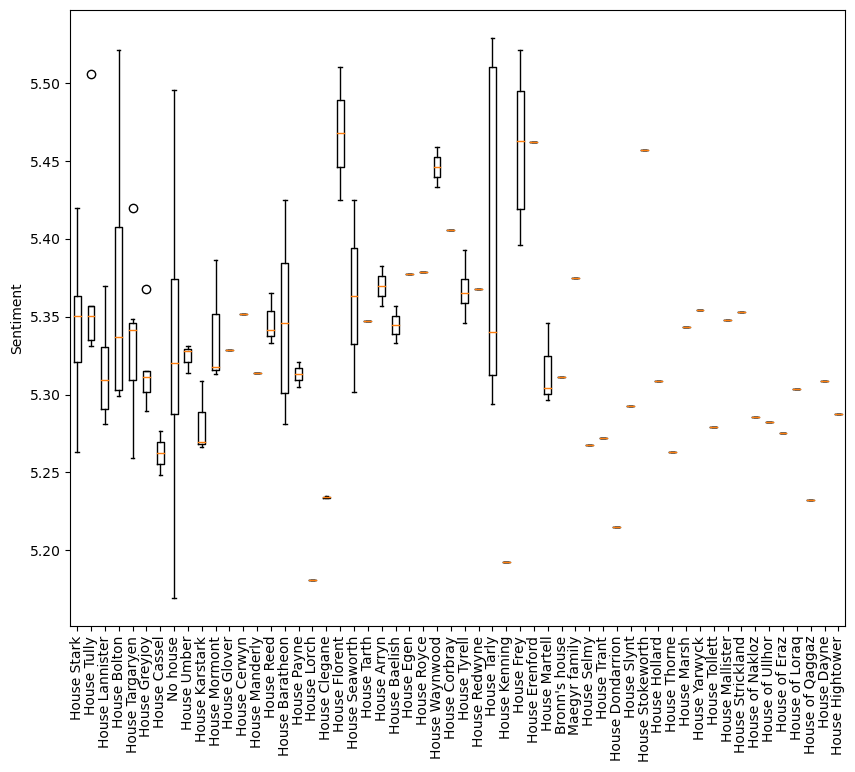

In [ ]:
houses_sentiments = {}
houses_avg_sentiment = {}
houses_std_sentiment = {}

# initialize house sentiments and size to 0
for house in houses_list:
    houses_sentiments[house] = []

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    all_houses = attributes['houses'].split(', ')

    sentiment = sentiments[node]
    
    for house in all_houses:
        houses_sentiments[house].append(sentiment)


# Calculate the average sentiment

for house in houses_list:
    houses_avg_sentiment[house] = np.mean(houses_sentiments[house])
    houses_std_sentiment[house] = np.std(houses_sentiments[house])

houses_avg_sentiment = dict(sorted(houses_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
mean_std_houses = np.mean(list(houses_std_sentiment.values()))
std_avg_houses = np.std(list(houses_avg_sentiment.values()))

plt.figure(figsize=(10, 8))
plt.boxplot([houses_sentiments[house] for house in houses_list])
plt.xticks(np.arange(1, len(houses_list)+1), houses_list, rotation=90)
plt.ylabel('Sentiment')
plt.show()

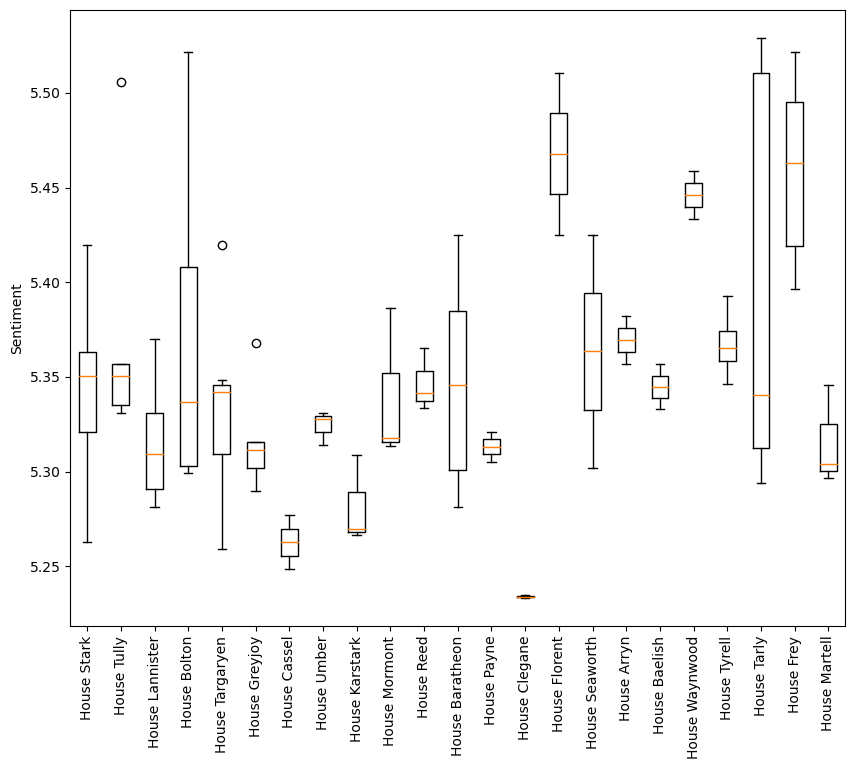

In [ ]:
houses_sentiments = {}
houses_avg_sentiment = {}
houses_std_sentiment = {}
houses_list_1 = []

# initialize house sentiments and size to 0
for house in houses_list:
    # only including houses with more than 1 member
    if house_sizes[house] > 1 and house != 'No house':
        houses_list_1.append(house)
        houses_sentiments[house] = []

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    all_houses = attributes['houses'].split(', ')

    sentiment = sentiments[node]
    
    for house in all_houses:
        if house_sizes[house] > 1 and house != 'No house':
            houses_sentiments[house].append(sentiment)


# Calculate the average sentiment

for house in houses_list_1:
    houses_avg_sentiment[house] = np.mean(houses_sentiments[house])
    houses_std_sentiment[house] = np.std(houses_sentiments[house])

houses_avg_sentiment = dict(sorted(houses_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
mean_std_houses = np.mean(list(houses_std_sentiment.values()))
std_avg_houses = np.std(list(houses_avg_sentiment.values()))

plt.figure(figsize=(10, 8))
plt.boxplot([houses_sentiments[house] for house in houses_list_1])
plt.xticks(np.arange(1, len(houses_list_1)+1), houses_list_1, rotation=90)
plt.ylabel('Sentiment')
plt.show()

In [ ]:
np.random.seed(42)
highest_house = list(houses_avg_sentiment.keys())[0]
print(highest_house)
highest_house_sentiment = houses_avg_sentiment[highest_house]
num_highest = house_sizes[highest_house]
print(f'Lowest house sentiment: {highest_house_sentiment}')
sentiments_values = sentiments_list.copy()
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_house_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups lower sentiment than the highest house: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

House Florent
Lowest house sentiment: 5.467773941951158
3
Fraction of randomly selected groups lower sentiment than the highest house: 0.003
Average random sentiment: 5.329665673356515


In [ ]:
np.random.seed(42)
lowest_house = list(houses_avg_sentiment.keys())[-1]
print(lowest_house)
lowest_house_sentiment = houses_avg_sentiment[lowest_house]
num_lowest = house_sizes[lowest_house]
print(f'Lowest house sentiment: {lowest_house_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_house_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups lower sentiment than the lowest house: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

House Clegane
Lowest house sentiment: 5.233960250251984
11
Fraction of randomly selected groups lower sentiment than the lowest house: 0.011
Average random sentiment: 5.328557928989497


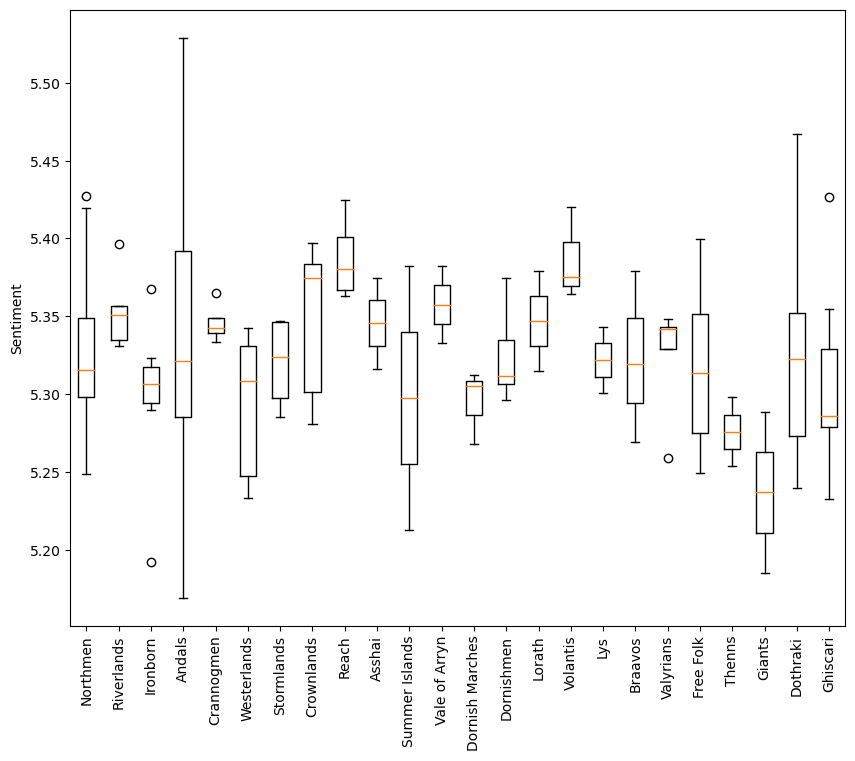

In [ ]:
culture_sentiments = {}
culture_avg_sentiment = {}
culture_std_sentiment = {}
cultures_list_1 = []

# initialize house sentiments and size to 0
for culture in cultures_list:
    if culture_sizes[culture] > 1 and culture != 'No culture':
        cultures_list_1.append(culture)
        culture_sentiments[culture] = []

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    culture = attributes['culture']
    if culture_sizes[culture] > 1 and culture != 'No culture':
        culture_sentiments[culture].append(sentiments[node])

# Calculate the average sentiment
for culture in cultures_list_1:
    culture_avg_sentiment[culture] = np.mean(culture_sentiments[culture]) 
    culture_std_sentiment[culture] = np.std(culture_sentiments[culture])

culture_avg_sentiment = dict(sorted(culture_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
mean_std_culture = np.mean(list(culture_std_sentiment.values()))
std_avg_culture = np.std(list(culture_avg_sentiment.values()))

plt.figure(figsize=(10, 8))
plt.boxplot([culture_sentiments[culture] for culture in cultures_list_1])
plt.xticks(np.arange(1, len(cultures_list_1)+1), cultures_list_1, rotation=90)
plt.ylabel('Sentiment')
plt.show()


In [ ]:
np.random.seed(42)
highest_culture = list(culture_avg_sentiment.keys())[0]
print(highest_culture)
highest_culture_sentiment = culture_avg_sentiment[highest_culture]
num_highest = culture_sizes[highest_culture]
print(f'Highest culture sentiment: {highest_culture_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_culture_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups higher sentiment than the highest culture: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Reach
Highest culture sentiment: 5.387168193793721
33
Fraction of randomly selected groups higher sentiment than the highest culture: 0.033
Average random sentiment: 5.328098976838849


In [ ]:
np.random.seed(42)
lowest_culture = list(culture_avg_sentiment.keys())[-1]
print(lowest_culture)
lowest_culture_sentiment = culture_avg_sentiment[lowest_culture]
num_lowest = culture_sizes[lowest_culture]
print(f'Lowest culture sentiment: {lowest_culture_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_culture_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups lower sentiment than the lowest culture: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Giants
Lowest culture sentiment: 5.236970698942176
18
Fraction of randomly selected groups lower sentiment than the lowest culture: 0.018
Average random sentiment: 5.330407982807731


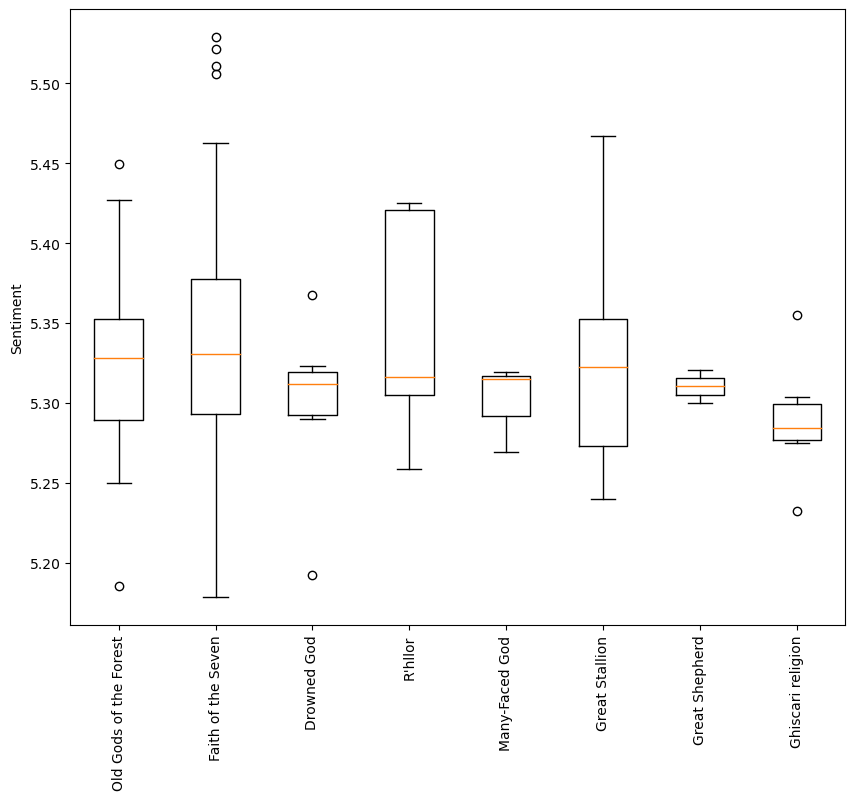

In [ ]:
religion_sentiments = {}
religion_avg_sentiment = {}
religion_std_sentiment = {}
religions_list_1 = []

# initialize house sentiments and size to 0
for religion in religions_list:
    if religion_sizes[religion] > 1 and religion != 'No religion':
        religions_list_1.append(religion)
        religion_sentiments[religion] = []

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    religion = attributes['religion']
    if religion_sizes[religion] > 1 and religion != 'No religion':
        religion_sentiments[religion].append(sentiments[node])

# Calculate the average sentiment
for religion in religions_list_1:
    religion_avg_sentiment[religion] = np.mean(religion_sentiments[religion])
    religion_std_sentiment[religion] = np.std(religion_sentiments[religion])

religion_avg_sentiment = dict(sorted(religion_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
mean_std_religion = np.mean(list(religion_std_sentiment.values()))
std_avg_religion = np.std(list(religion_avg_sentiment.values()))

# make a box plot of the sentiments
plt.figure(figsize=(10, 8))
plt.boxplot([religion_sentiments[religion] for religion in religions_list_1])
plt.xticks(np.arange(1, len(religions_list_1)+1), religions_list_1, rotation=90)
plt.ylabel('Sentiment')
plt.show()



In [ ]:
np.random.seed(42)
highest_religion = list(religion_avg_sentiment.keys())[0]
print(highest_religion)
highest_religion_sentiment = religion_avg_sentiment[highest_religion]
num_highest = religion_sizes[highest_religion]
print(f'Highest religion sentiment: {highest_religion_sentiment}')

count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_religion_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups higher sentiment than the highest culture: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

R'hllor
Highest religion sentiment: 5.345551209714973
230
Fraction of randomly selected groups higher sentiment than the highest culture: 0.23
Average random sentiment: 5.330234114928149


In [ ]:
np.random.seed(42)
lowest_religion = list(religion_avg_sentiment.keys())[-1]
print(lowest_religion)
lowest_religion_sentiment = religion_avg_sentiment[lowest_religion]
num_lowest = religion_sizes[lowest_religion]
print(f'Lowest religion sentiment: {lowest_religion_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_religion_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups lower sentiment than the lowest religion: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Ghiscari religion
Lowest religion sentiment: 5.2890936981456385
49
Fraction of randomly selected groups lower sentiment than the lowest religion: 0.049
Average random sentiment: 5.330332752244946


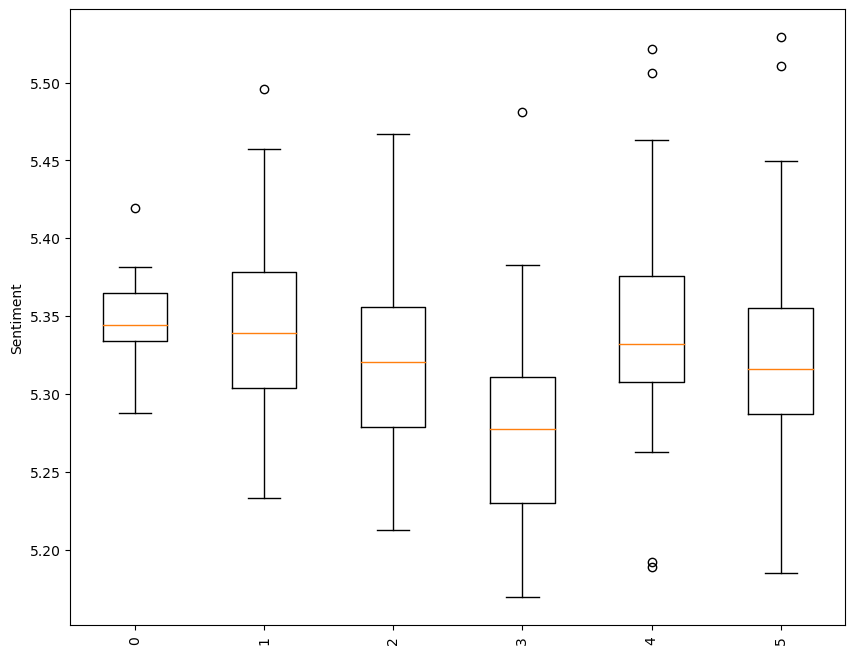

In [ ]:
# calculate the sentiment scores of the best_partition communities
best_partition_sentiments = {}
best_partition_avg_sentiment = {}
best_partition_std_sentiment = {}

# initialize house sentiments and size to 0
for community in set(best_partition.values()):
    best_partition_sentiments[community] = []

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    community = best_partition[node]
    best_partition_sentiments[community].append(sentiments[node])

# Calculate the average sentiment
for community in set(best_partition.values()):
    best_partition_avg_sentiment[community] = np.mean(best_partition_sentiments[community])
    best_partition_std_sentiment[community] = np.std(best_partition_sentiments[community])

best_partition = dict(sorted(best_partition.items(), key=lambda x: x[1], reverse=True))

mean_std_best_partition = np.mean(list(best_partition_std_sentiment.values()))
std_avg_best_partition = np.std(list(best_partition_avg_sentiment.values()))

# make a box plot of the sentiments
plt.figure(figsize=(10, 8))
plt.boxplot([best_partition_sentiments[community] for community in set(best_partition.values())])
plt.xticks(np.arange(1, len(set(best_partition.values()))+1), set(best_partition.values()), rotation=90)
plt.ylabel('Sentiment')
plt.show()


In [ ]:
np.random.seed(42)
highest_best_partition = list(best_partition_avg_sentiment.keys())[0]
print(highest_best_partition)
highest_best_partition_sentiment = best_partition_avg_sentiment[highest_best_partition]
num_highest = best_partition_sizes[highest_best_partition]
print(f'Highest best_partition sentiment: {highest_best_partition_sentiment}')

count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_best_partition_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups higher sentiment than the highest best_partition: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

0
Highest best_partition sentiment: 5.348817290993421
173
Fraction of randomly selected groups higher sentiment than the highest best_partition: 0.173
Average random sentiment: 5.329675282176125


In [ ]:
np.random.seed(42)
lowest_best_partition = list(best_partition_avg_sentiment.keys())[-1]
print(lowest_best_partition)
lowest_best_partition_sentiment = best_partition_avg_sentiment[lowest_best_partition]
num_lowest = best_partition_sizes[lowest_best_partition]
print(f'Lowest best_partition sentiment: {lowest_best_partition_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_best_partition_sentiment:
        count += 1
print(count)
print(f'Fraction of randomly selected groups lower sentiment than the lowest best_partition: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

5
Lowest best_partition sentiment: 5.328503757187864
455
Fraction of randomly selected groups lower sentiment than the lowest best_partition: 0.455
Average random sentiment: 5.329726491438547


In [ ]:
# print all the mean stds
print(f'mean std houses: {mean_std_houses}')
print(f'std avg houses: {std_avg_houses}')
print(f'number of houses: {len(houses_list_1)}')
print('\n')
print(f'mean std culture: {mean_std_culture}')
print(f'std avg culture: {std_avg_culture}')
print(f'number of cultures 1: {len(cultures_list_1)}')
print('\n')
print(f'mean std religion: {mean_std_religion}')
print(f'std avg religion: {std_avg_religion}')
print(f'number of religions 1: {len(religions_list_1)}')
print('\n')
print(f'mean std best partition: {mean_std_best_partition}')
print(f'std avg best partition: {std_avg_best_partition}')
print(f'number of communities: {len(set(best_partition.values()))}')


mean std houses: 0.03340528019565616
std avg houses: 0.05554880203734759
number of houses: 23


mean std culture: 0.03940350949167148
std avg culture: 0.03251697221303081
number of cultures 1: 24


mean std religion: 0.04690220159174366
std avg religion: 0.018875394630541678
number of religions 1: 8


mean std best partition: 0.05848883197752617
std avg best partition: 0.023985996587075707
number of communities: 6


In [ ]:
# get raw text from all characters in lowest_house
lowest_house_file_names = []
highest_house_file_names = []
lowest_culture_file_names = []
highest_culture_file_names = []
lowest_religion_file_names = []
highest_religion_file_names = []
for node, attributes in di_G.nodes(data=True):
    houses = attributes['houses'].split(', ')
    culture = attributes['culture']
    religion = attributes['religion']
    file_name = node + '.txt'
    if lowest_house in houses:
        lowest_house_file_names.append(file_name)
    elif highest_house in houses:
        highest_house_file_names.append(file_name)
    if lowest_culture == culture:
        lowest_culture_file_names.append(file_name)
    elif highest_culture == culture:
        highest_culture_file_names.append(file_name)
    if lowest_religion == religion:
        lowest_religion_file_names.append(file_name)
    elif highest_religion == religion:
        highest_religion_file_names.append(file_name)


lowest_house_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_house_file_names)

highest_house_corpus = PlaintextCorpusReader('files/wiki_texts', highest_house_file_names)

lowest_house_raw = lowest_house_corpus.raw()
highest_house_raw = highest_house_corpus.raw()

lowest_culture_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_culture_file_names)

highest_culture_corpus = PlaintextCorpusReader('files/wiki_texts', highest_culture_file_names)

lowest_culture_raw = lowest_culture_corpus.raw()
highest_culture_raw = highest_culture_corpus.raw()

lowest_religion_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_religion_file_names)
highest_religion_corpus = PlaintextCorpusReader('files/wiki_texts', highest_religion_file_names)

lowest_religion_raw = lowest_religion_corpus.raw()
highest_religion_raw = highest_religion_corpus.raw()


In [ ]:
dict_lowest_house_TFTR, dict_highest_house_TFTR, fdist_lowest_house, fdist_highest_house = get_TFTR(lowest_house_raw, highest_house_raw, c = 1)

dict_lowest_house_TFTR_weighted, dict_highest_house_TFTR_weighted, _, _ = get_TFTR(lowest_house_raw, highest_house_raw, c = 1, weighted=True)

min_lowest_house_TFTR = min(dict_lowest_house_TFTR.values())
min_highest_house_TFTR = min(dict_highest_house_TFTR.values())
min_lowest_house_TFTR_weighted = min(dict_lowest_house_TFTR_weighted.values())
min_highest_house_TFTR_weighted = min(dict_highest_house_TFTR_weighted.values())

print("Top 5 words in the text from the characters with lowest houses")
for i, w in enumerate(fdist_lowest_house):
    if i >= 10:
        break
    print(w, fdist_lowest_house[w])

print("\nTop 5 words in the text from the characters with highest house")
for i, w in enumerate(fdist_highest_house):
    if i >= 10:
        break
    print(w, fdist_highest_house[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest house")
for i, w in enumerate(dict_lowest_house_TFTR):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest houses")
for i, w in enumerate(dict_lowest_house_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR_weighted[w])
    

Top 5 words in the text from the characters with lowest houses
sandor 319
gregor 242
arya 133
clegane 117
cersei 101
season 86
file 71
brother 60
thrones 59
king 58

Top 5 words in the text from the characters with highest house
selyse 64
stannis 45
house 33
baratheon 31
season 31
thrones 26
game 25
melisandre 25
shireen 23
florent 20

Top 5 TF-TR scores in the text from the characters with lowest house
sandor 101761.0
gregor 58564.0
arya 17689.0
clegane 13689.0
cersei 10201.0
man 3136.0
hound 3025.0
sansa 1936.0
lannister 1849.0
beric 1764.0

Top 5 TF-TR scores in the text from the characters with highest house
selyse 4096.0
shireen 529.0
stannis 405.0
florent 400.0
melessa 324.0
tarly 200.0
gilly 144.0
wife 121.0
melisandre 89.28571428571429
stillborn 81.0

Top 5 weighted TF-TR scores in the text from the characters with lowest houses
sandor 3341.9681313008286
gregor 1923.3205416761011
arya 580.93055566062
clegane 449.5651747661387
cersei 335.014562626151
man 102.99045862127338
hound

In [ ]:
lowest_house_str = ""
highest_house_str = ""

for w in dict_lowest_house_TFTR:
    for i in range(int(dict_lowest_house_TFTR[w]/min_lowest_house_TFTR)):
        lowest_house_str += w + " "

for w in dict_highest_house_TFTR:
    for i in range(int(dict_highest_house_TFTR[w]/min_highest_house_TFTR)):
        highest_house_str += w + " "

lowest_house_str_weighted = ""
highest_house_str_weighted = ""
for w in dict_lowest_house_TFTR_weighted:
    for i in range(int(dict_lowest_house_TFTR_weighted[w]/min_lowest_house_TFTR_weighted)):
        lowest_house_str_weighted += w + " "

for w in dict_highest_house_TFTR_weighted:
    for i in range(int(dict_highest_house_TFTR_weighted[w]/min_highest_house_TFTR_weighted)):
        highest_house_str_weighted += w + " "

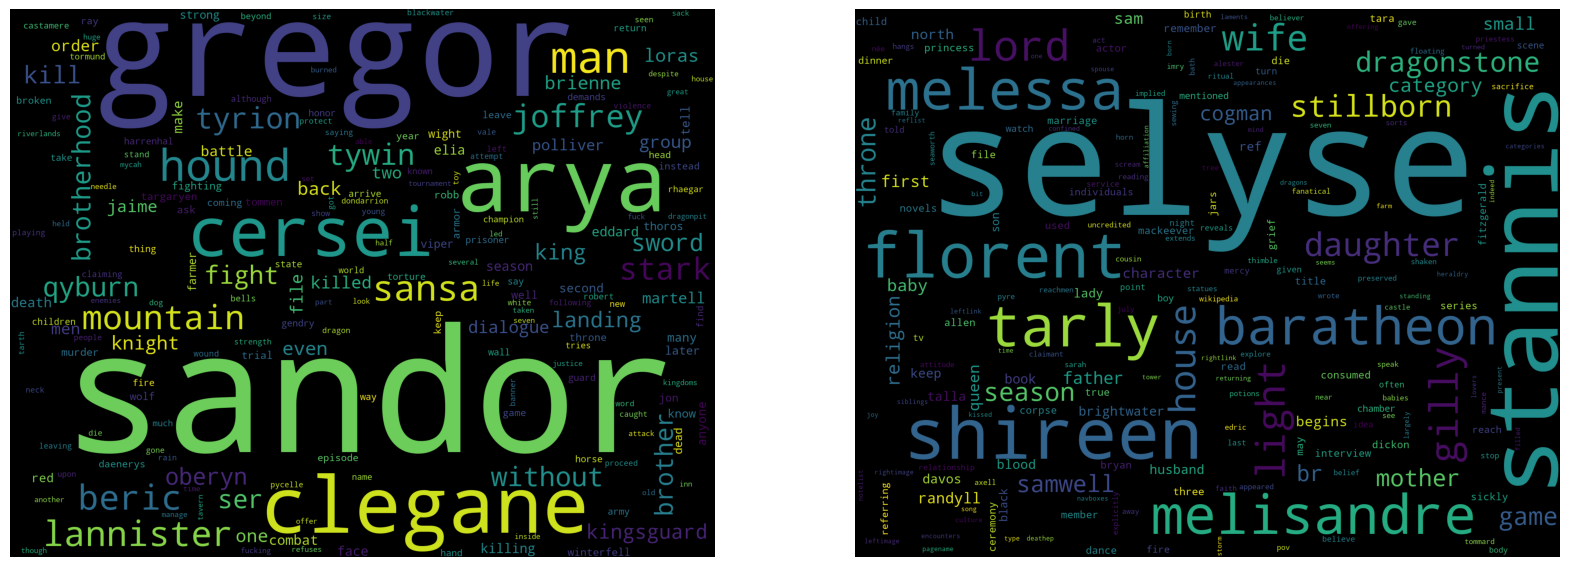

In [ ]:
lowest_house_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_house_str_weighted)
                     
highest_house_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_house_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_house_weighted_wordcloud)
ax[0].axis('off')
ax[1].imshow(highest_house_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [ ]:
dict_lowest_house_TFTR_sentiment, dict_highest_house_TFTR_sentiment, fdist_lowest_house_sentiment, fdist_highest_house_sentiment = get_TFTR(lowest_house_raw, highest_house_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_house_TFTR_sentiment_weighted, dict_highest_house_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_house_raw, highest_house_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_house_TFTR_sentiment = min(dict_lowest_house_TFTR_sentiment.values())
min_highest_house_TFTR_sentiment = min(dict_highest_house_TFTR_sentiment.values())
min_lowest_house_TFTR_sentiment_weighted = min(dict_lowest_house_TFTR_sentiment_weighted.values())
min_highest_house_TFTR_sentiment_weighted = min(dict_highest_house_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest houses")
for i, w in enumerate(fdist_lowest_house_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_house_sentiment[w])

print("\nTop 5 words in the text from the characters with highest house")
for i, w in enumerate(fdist_highest_house_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_house_sentiment[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest house")
for i, w in enumerate(dict_lowest_house_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR_sentiment[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest houses")
for i, w in enumerate(dict_lowest_house_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR_sentiment_weighted[w])
    

Top 5 words in the text from the characters with lowest houses
season 86
file 71
brother 60
king 58
game 57
one 57
man 56
hound 55
ser 44
house 43

Top 5 words in the text from the characters with highest house
house 33
season 31
game 25
lord 19
daughter 17
light 16
category 13
father 11
mother 11
wife 11

Top 5 TF-TR scores in the text from the characters with lowest house
man 3136.0
hound 3025.0
mountain 1681.0
without 1089.0
ser 968.0
brother 900.0
fight 900.0
sword 784.0
landing 676.0
king 672.8

Top 5 TF-TR scores in the text from the characters with highest house
wife 121.0
lord 51.57142857142858
light 51.2
sam 25.0
house 24.75
daughter 24.083333333333336
husband 16.0
mother 13.444444444444446
religion 12.25
baby 12.0

Top 5 weighted TF-TR scores in the text from the characters with lowest houses
man 104.31556758245623
hound 100.6232754900925
mountain 55.91660366903983
without 36.2243791764333
ser 32.1994481568296
brother 29.937503451597763
fight 29.937503451597763
sword 26.07889

In [ ]:

lowest_house_sentiment_str = ""
highest_house_sentiment_str = ""

for w in dict_lowest_house_TFTR_sentiment:
    for i in range(int(dict_lowest_house_TFTR_sentiment[w]/min_lowest_house_TFTR_sentiment)):
        lowest_house_sentiment_str += w + " "

for w in dict_highest_house_TFTR_sentiment:
    for i in range(int(dict_highest_house_TFTR_sentiment[w]/min_highest_house_TFTR_sentiment)):
        highest_house_sentiment_str += w + " "

lowest_house_sentiment_str_weighted = ""
highest_house_sentiment_str_weighted = ""
for w in dict_lowest_house_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_house_TFTR_sentiment_weighted[w]/min_lowest_house_TFTR_sentiment_weighted)):
        lowest_house_sentiment_str_weighted += w + " "

for w in dict_highest_house_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_house_TFTR_sentiment_weighted[w]/min_highest_house_TFTR_sentiment_weighted)):
        highest_house_sentiment_str_weighted += w + " "

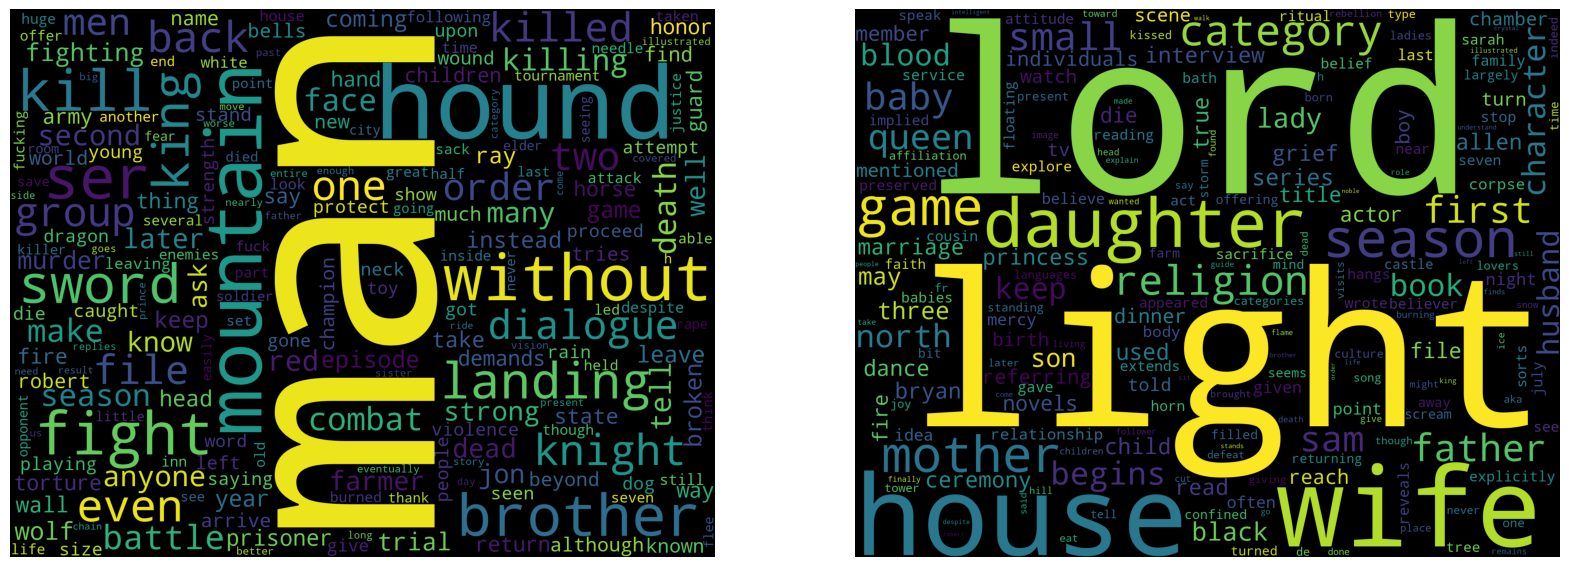

In [ ]:
lowest_house_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_house_sentiment_str_weighted)


highest_house_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_house_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_house_sentiment_weighted_wordcloud)
ax[0].axis('off')

ax[1].imshow(highest_house_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [ ]:
dict_lowest_culture_TFTR_sentiment, dict_highest_culture_TFTR_sentiment, fdist_lowest_culture_sentiment, fdist_highest_culture_sentiment = get_TFTR(lowest_culture_raw, highest_culture_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_culture_TFTR_sentiment_weighted, dict_highest_culture_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_culture_raw, highest_culture_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_culture_TFTR_sentiment = min(dict_lowest_culture_TFTR_sentiment.values())
min_highest_culture_TFTR_sentiment = min(dict_highest_culture_TFTR_sentiment.values())
min_lowest_culture_TFTR_sentiment_weighted = min(dict_lowest_culture_TFTR_sentiment_weighted.values())
min_highest_culture_TFTR_sentiment_weighted = min(dict_highest_culture_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest culture")
for i, w in enumerate(fdist_lowest_culture_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_culture_sentiment[w])

print("\nTop 5 words in the text from the characters with highest culture")
for i, w in enumerate(fdist_highest_culture_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_culture_sentiment[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest culture")
for i, w in enumerate(dict_lowest_culture_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_culture_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest culture")
for i, w in enumerate(dict_highest_culture_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_culture_TFTR_sentiment[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest culture")
for i, w in enumerate(dict_lowest_culture_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_culture_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest culture")
for i, w in enumerate(dict_highest_culture_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_culture_TFTR_sentiment_weighted[w])
    

Top 5 words in the text from the characters with lowest culture
mag 34
jon 30
weg 20
giants 20
wall 19
game 18
season 17
battle 16
giant 14
back 10

Top 5 words in the text from the characters with highest culture
house 139
season 109
file 91
game 89
king 84
high 58
queen 54
one 52
death 49
would 47

Top 5 TF-TR scores in the text from the characters with lowest culture
mag 1156.0
weg 400.0
giants 400.0
wall 361.0
jon 300.0
giant 196.0
mar 81.0
bastards 64.0
mighty 36.0
dar 36.0

Top 5 TF-TR scores in the text from the characters with highest culture
house 6440.333333333334
high 3364.0
queen 2916.0
would 2209.0
faith 2025.0
landing 1444.0
wedding 1225.0
sept 1225.0
file 1183.0
lord 1156.0

Top 5 weighted TF-TR scores in the text from the characters with lowest culture
mag 1156.0
jon 738.8609715242882
weg 400.0
giants 400.0
wall 361.0
giant 196.0
battle 101.32041274113952
mar 81.0
bastards 64.0
back 47.83646025376857

Top 5 weighted TF-TR scores in the text from the characters with high

In [ ]:

lowest_culture_sentiment_str = ""
highest_culture_sentiment_str = ""

for w in dict_lowest_culture_TFTR_sentiment:
    for i in range(int(dict_lowest_culture_TFTR_sentiment[w]/min_lowest_culture_TFTR_sentiment)):
        lowest_culture_sentiment_str += w + " "

for w in dict_highest_culture_TFTR_sentiment:
    for i in range(int(dict_highest_culture_TFTR_sentiment[w]/min_highest_culture_TFTR_sentiment)):
        highest_culture_sentiment_str += w + " "

lowest_culture_sentiment_str_weighted = ""
highest_culture_sentiment_str_weighted = ""
for w in dict_lowest_culture_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_culture_TFTR_sentiment_weighted[w]/min_lowest_culture_TFTR_sentiment_weighted)):
        lowest_culture_sentiment_str_weighted += w + " "

for w in dict_highest_culture_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_culture_TFTR_sentiment_weighted[w]/min_highest_culture_TFTR_sentiment_weighted)):
        highest_culture_sentiment_str_weighted += w + " "

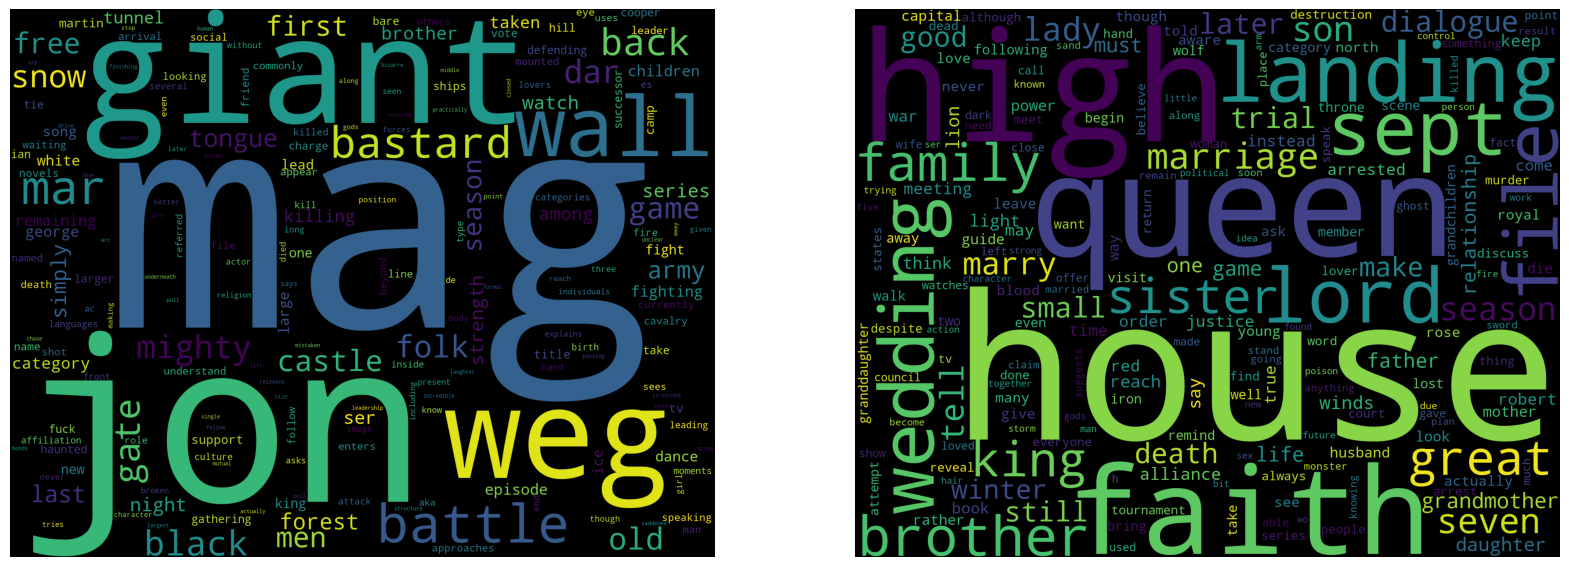

In [ ]:
lowest_culture_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_culture_sentiment_str_weighted)


highest_culture_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_culture_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_culture_sentiment_weighted_wordcloud)
ax[0].axis('off')

ax[1].imshow(highest_culture_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [ ]:
dict_lowest_religion_TFTR_sentiment, dict_highest_religion_TFTR_sentiment, fdist_lowest_religion_sentiment, fdist_highest_religion_sentiment = get_TFTR(lowest_religion_raw, highest_religion_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_religion_TFTR_sentiment_weighted, dict_highest_religion_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_religion_raw, highest_religion_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_religion_TFTR_sentiment = min(dict_lowest_culture_TFTR_sentiment.values())
min_highest_religion_TFTR_sentiment = min(dict_highest_culture_TFTR_sentiment.values())
min_lowest_religion_TFTR_sentiment_weighted = min(dict_lowest_culture_TFTR_sentiment_weighted.values())
min_highest_religion_TFTR_sentiment_weighted = min(dict_highest_culture_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest religion")
for i, w in enumerate(fdist_lowest_religion_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_religion_sentiment[w])

print("\nTop 5 words in the text from the characters with highest religion")
for i, w in enumerate(fdist_highest_religion_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_religion_sentiment[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest religion")
for i, w in enumerate(dict_lowest_religion_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_religion_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest religion")
for i, w in enumerate(dict_highest_religion_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_religion_TFTR_sentiment[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest religion")
for i, w in enumerate(dict_lowest_religion_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_religion_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest religion")
for i, w in enumerate(dict_highest_religion_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_religion_TFTR_sentiment_weighted[w])
    

Top 5 words in the text from the characters with lowest religion
masters 61
season 46
mo 43
game 42
zo 34
sons 33
one 31
category 28
house 26
city 26

Top 5 words in the text from the characters with highest religion
season 145
jon 137
lord 123
game 120
king 109
file 104
light 102
house 91
one 83
battle 82

Top 5 TF-TR scores in the text from the characters with lowest religion
mo 1849.0
zo 1156.0
masters 744.1999999999999
pit 400.0
wise 176.33333333333334
slaves 81.0
grey 49.0
worm 49.0
city 45.06666666666667
fighting 44.1

Top 5 TF-TR scores in the text from the characters with highest religion
jon 18769.0
lord 15129.0
light 10404.0
red 3042.0
north 2916.0
king 2376.2000000000003
castle 2116.0
night 2048.0
brother 1936.0
robert 1925.3333333333333

Top 5 weighted TF-TR scores in the text from the characters with lowest religion
masters 1910.8005674232309
mo 1849.0
zo 1156.0
pit 400.0
wise 358.9663689491675
slaves 189.4168052059089
city 156.63631913852177
sons 142.6987905629844
fightin

In [ ]:
lowest_religion_sentiment_str = ""
highest_religion_sentiment_str = ""

for w in dict_lowest_religion_TFTR_sentiment:
    for i in range(int(dict_lowest_religion_TFTR_sentiment[w]/min_lowest_religion_TFTR_sentiment)):
        lowest_religion_sentiment_str += w + " "

for w in dict_highest_religion_TFTR_sentiment:
    for i in range(int(dict_highest_religion_TFTR_sentiment[w]/min_highest_religion_TFTR_sentiment)):
        highest_religion_sentiment_str += w + " "

lowest_religion_sentiment_str_weighted = ""
highest_religion_sentiment_str_weighted = ""
for w in dict_lowest_religion_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_religion_TFTR_sentiment_weighted[w]/min_lowest_religion_TFTR_sentiment_weighted)):
        lowest_religion_sentiment_str_weighted += w + " "

for w in dict_highest_religion_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_religion_TFTR_sentiment_weighted[w]/min_highest_religion_TFTR_sentiment_weighted)):
        highest_religion_sentiment_str_weighted += w + " "

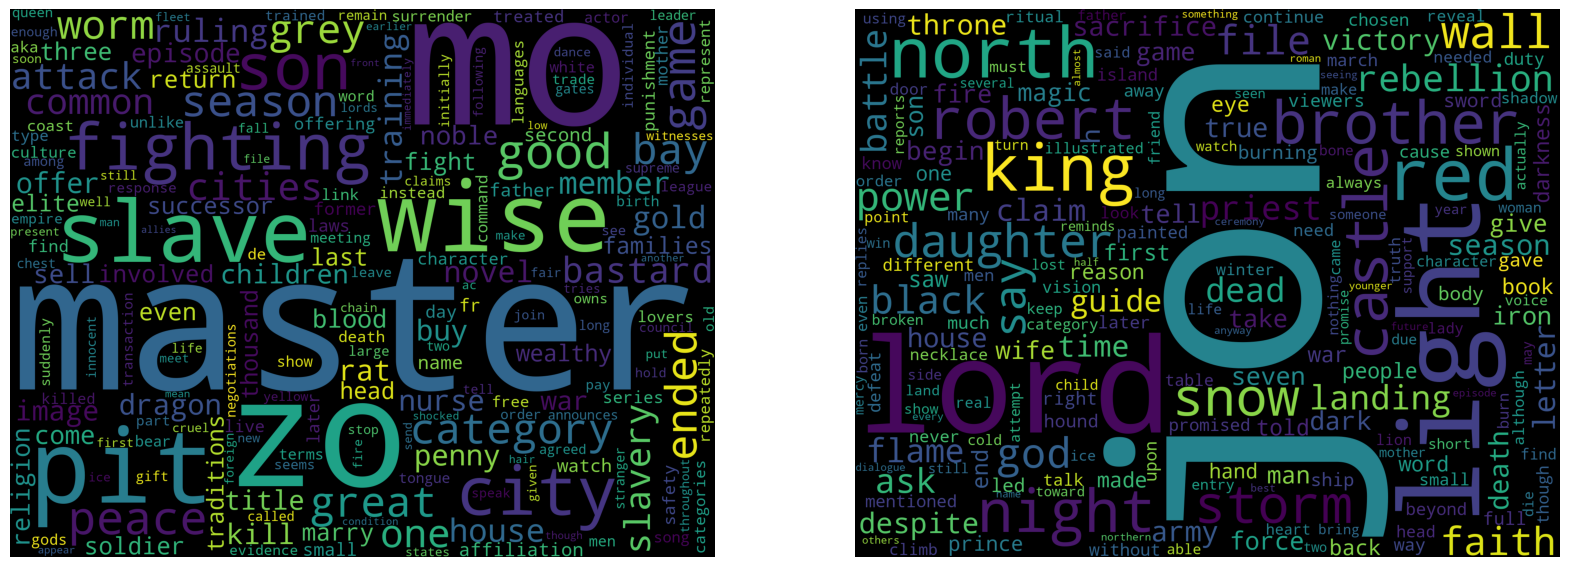

In [ ]:
lowest_religion_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_religion_sentiment_str_weighted)


highest_religion_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_religion_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_religion_sentiment_weighted_wordcloud)
ax[0].axis('off')

ax[1].imshow(highest_religion_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()